In [1]:
# Load general package

import os
import sys

import copy
import numpy as np
from astropy.cosmology import Planck18

PACKAGE_PARENT = '..'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd())))
sys.path.append(SCRIPT_DIR)

In [2]:
#Line 955 for IMRPhenomD

import gwfast.gwfastGlobals as glob

from legwork import source, psd
from astropy import units as u

In [3]:
import numpy as np

import time
import sys
import os

import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import rc

from astropy.cosmology import Planck18

import gwfast.waveforms as WF
import WFutils as utils

ourcodenameString = 'WF4Py'

import pycbc.waveform
import pycbc.types as pcbcdt


/home/zihanz/gwfast/gwfast/waveforms.py:34: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


In [4]:
def m1m2_from_Mceta(Mc, eta):
    # Define a function to compute the component masses of a binary given its chirp mass and symmetric mass ratio
    m1 = 0.5*(Mc/(eta**(3./5.)))*(1.+np.sqrt(1.-4.*eta))
    m2 = 0.5*(Mc/(eta**(3./5.)))*(1.-np.sqrt(1.-4.*eta))

    return m1, m2

In [52]:
zs = np.array([.1])

events = {'Mc':np.array([2])*(1.+zs), 'dL':(Planck18.luminosity_distance(zs).value/1000.),
         'iota':np.array([.0]), 'eta':np.array([0.24]), 'chi1z':np.array([0.8]), 'chi2z':np.array([-0.8]),
          'Lambda1':np.array([0.]), 'Lambda2':np.array([0.])}

events_Diss = {'Mc':np.array([2])*(1.+zs), 'dL':(Planck18.luminosity_distance(zs).value/1000.),
         'iota':np.array([.0]), 'eta':np.array([0.24]), 'chi1z':np.array([0.8]), 'chi2z':np.array([-0.8]),
          'Lambda1':np.array([100.]), 'Lambda2':np.array([100.]),'H1s0wE':np.array([100]),'H2s0wE':np.array([100])}


In [53]:
tmpWF = WF.IMRPhenomD()
tmpWF_Diss = WF.IMRPhenomD_Diss()

fcut = tmpWF.fcut(**events)
fminarr = np.full(fcut.shape, 5)
fgrids = np.geomspace(fminarr, 1000, num=int(1000))

In [54]:
myampl_Diss = tmpWF.Ampl(fgrids, **events_Diss)
myphase_Diss = tmpWF_Diss.Phi(fgrids, **events_Diss)
myphase_Diss = [x.item() for x in myphase_Diss]

2.159853125023328


In [55]:
myampl = tmpWF.Ampl(fgrids, **events)
myphase = tmpWF.Phi(fgrids, **events)
myphase = [x.item() for x in myphase]

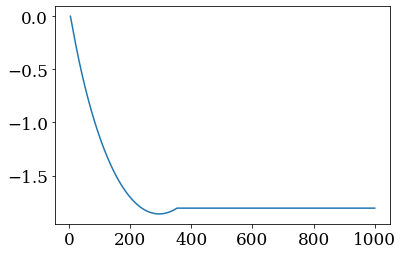

In [56]:
plt.plot(fgrids,np.array(myphase)-np.array(myphase_Diss))

In [8]:
m1s, m2s = m1m2_from_Mceta(events['Mc'], events['eta'])

hp, hc = pycbc.waveform.get_fd_waveform_sequence(approximant='IMRPhenomD',
                                                    mass1=m1s,
                                                    mass2=m2s,
                                                    spin1z=events['chi1z'],
                                                    spin2z=events['chi2z'],
                                                    sample_points = pcbcdt.array.Array(fgrids[:,0]),
                                                    distance=events['dL']*1000.)

PyCBCwfAmpl = np.array(abs(hp))
PyCBCwfPhase = np.array(hp/abs(hp))

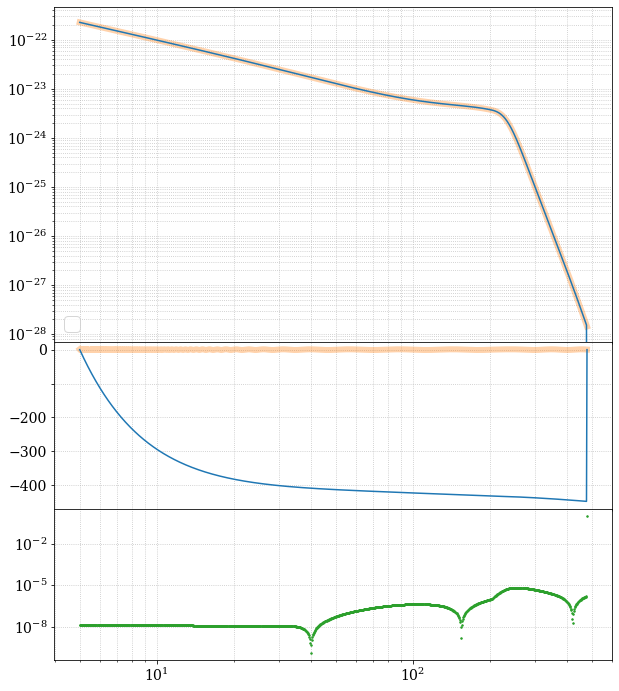

In [9]:
fig = plt.figure(figsize=(10,12))
gs = gridspec.GridSpec(3,1,height_ratios=[2,1,.9])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1], sharex=ax1)
ax3 = plt.subplot(gs[2], sharex=ax1)
ax1.plot(fgrids, PyCBCwfAmpl, 'C1', alpha=.35, linewidth=6.)
ax1.plot(fgrids, myampl, 'C0')
ax1.set_yscale('log')
#ax1.set_ylabel(r'$A_+ \, ({\rm Hz}^{-1})$',fontsize=20)
ax1.grid()
ax2.plot(fgrids, PyCBCwfPhase.real, 'C1', alpha=.35, linewidth=6.)
ax2.plot(fgrids[:,0], myphase, 'C0',) ###joshmod
#ax2.set_ylabel(r'$\cos(\Psi_{+})$', fontsize=20)
#plt.xlabel(r'$f \, (\rm Hz)$', fontsize=20)
yticks = ax2.yaxis.get_major_ticks()
yticks[-1].label1.set_visible(False)
ax3.plot(fgrids[:,0], abs(1.-(myampl[:,0])/(PyCBCwfAmpl)), '.', color='C2', ms=3)
#ax3.set_ylabel(r'$\rm res$', fontsize=20)
ax1.set_xscale('log')
ax3.set_yscale('log')

plt.subplots_adjust(hspace=0.)

handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[::-1], labels[::-1], loc='lower left', fontsize=20)

ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(axis='both', which='minor', labelsize=14)
ax2.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='both', which='minor', labelsize=14)
ax3.tick_params(axis='both', which='major', labelsize=14)
ax3.tick_params(axis='both', which='minor', labelsize=14)

#plt.xlim(min(fgrids), max(fgrids))
ax1.grid(True, which='both', ls='dotted', linewidth='0.8', alpha=.8)
ax2.grid(True, which='both', ls='dotted', linewidth='0.8', alpha=.8)
ax3.grid(True, which='both', ls='dotted', linewidth='0.8', alpha=.8)

#ax1.set_title(r"{$\bf \texttt{IMRPhenomD}$}", fontsize=25)

plt.show()